# Introduction

## 1. Import libraries

Import all the necessary libraries required to execute the code

In [30]:
import os
from kaggle.api.kaggle_api_extended import KaggleApi

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.filters.hp_filter import hpfilter
from statsmodels.nonparametric.smoothers_lowess import lowess
from statsmodels.tsa.seasonal import STL
import math
import calendar


## 2. Data Import
The following code cell is used to download the dataset files from the Kaggle website. It only needs to be executed once.  
Additionally, you will need to generate a personal Kaggle API Token in your account settings and install kaggle (pip install kaggle)

In [2]:
# def download_kaggle_dataset(dataset, path="data"):
#     if not os.path.exists(path):
#         os.makedirs(path)

#     api = KaggleApi()
#     api.authenticate()
#     api.dataset_download_files(dataset, path=path, unzip=True)
#     print("Dataset downloaded and extracted.")

# if __name__ == "__main__":
#     download_kaggle_dataset("arashnic/food-demand")

Based on the _['retail-demand-analysis'](https://github.com/AwanRaskall/retail-demand-analysis)_ project, **Center №13** was identified as the most active in terms of order frequency and volume. Therefore, it has been selected as the primary focus for our forecasting model since:

1. More data → More orders means more historical data for the model, which means better forecast quality.
2. Pattern stability → Stores with high activity tend to have more predictable trends.
3. Minimize outliers → Stores with high costs but low orders may have unstable purchases, which will make forecasting more difficult.

In [3]:
df = pd.read_csv('data/foodDemand_train/train.csv')
df_orders = df[df['center_id'] == 13].reset_index(drop = True)
df_orders

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders
0,1171094,1,13,1885,135.86,122.28,0,1,2132
1,1068455,1,13,1993,134.86,122.28,0,1,2418
2,1105491,1,13,2539,133.86,133.86,0,0,474
3,1486384,1,13,2139,337.62,437.53,0,0,123
4,1345938,1,13,2631,252.23,437.47,0,0,162
...,...,...,...,...,...,...,...,...,...
7041,1385493,145,13,1543,484.03,485.03,0,0,270
7042,1076678,145,13,2304,486.03,485.03,0,0,149
7043,1012260,145,13,2664,241.59,335.62,0,0,770
7044,1268089,145,13,2569,241.53,337.56,0,0,798


## 3. First acquaintance with data

In [4]:
df_orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7046 entries, 0 to 7045
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     7046 non-null   int64  
 1   week                   7046 non-null   int64  
 2   center_id              7046 non-null   int64  
 3   meal_id                7046 non-null   int64  
 4   checkout_price         7046 non-null   float64
 5   base_price             7046 non-null   float64
 6   emailer_for_promotion  7046 non-null   int64  
 7   homepage_featured      7046 non-null   int64  
 8   num_orders             7046 non-null   int64  
dtypes: float64(2), int64(7)
memory usage: 495.6 KB


### 3.1. The center description

In [5]:
df_center = pd.read_csv('data/foodDemand_train/fulfilment_center_info.csv')
df_center[df_center['center_id'] == 13]

,center_id,city_code,region_code,center_type,op_area
1,13,590,56,TYPE_B,6.7


In [6]:
num_meals = df_orders['num_orders'].sum()
print(f'Total number of products ordered by center 13: {num_meals}')

Total number of products ordered by center 13: 4296545


In [7]:
df_orders['Total costs'] = df_orders.checkout_price * df_orders.num_orders
df_orders = df_orders.reset_index(drop = True)

total_costs_orders = df_orders['Total costs'].sum()
print(f'Total costs of orders for all products by center 13: {total_costs_orders}')

Total costs of orders for all products by center 13: 1127045001.1799998


Thus, the Center №13 based in city №590 and being B-type class made 7 046 orders for 4 296 545 units of products and for a total of 1 127 045 001,18 conventional monetary units over 145 weeks

### 3.2. The meal description

To create a forecasting model, we will focus on one type of product that was ordered most often or in large volumes

In [8]:
meals_num_orders = df_orders.groupby('meal_id').size().reset_index(name='num_orders')
meals_num_orders = meals_num_orders.sort_values(by = 'num_orders', ascending = False).reset_index(drop = True)

top_meal_orders = meals_num_orders.head(10)
top_meal_orders

,meal_id,num_orders
0,1062,145
1,1109,145
2,1198,145
3,1445,145
4,1311,145
5,1778,145
6,1558,145
7,1727,145
8,1754,145
9,2707,145


Since the number of orders for each product is equal, then let's calculate which product was ordered the largest number of units

In [9]:
meals_num_units = df_orders.groupby('meal_id')['num_orders'].sum().reset_index(name='num_orders')
meals_num_units = meals_num_units.sort_values(by = 'num_orders', ascending = False).reset_index(drop = True)

top_meal_units = meals_num_units.head(1)
print(f'The product with the highest number of units ordered was meal №{top_meal_units.iloc[0,0]}, amounting to {top_meal_units.iloc[0,1]} units')

The product with the highest number of units ordered was meal №1885, amounting to 334334 units


In [10]:
df_meal = pd.read_csv('data/foodDemand_train/meal_info.csv')
df_meal[df_meal['meal_id'] == 1885]

,meal_id,category,cuisine
0,1885,Beverages,Thai


To sum up, the most popular product in Center №13 was the Thai drink №1885. Given it was consistently ordered over 145 weeks with a total volume of 334 334 units across 145 separate orders, it demonstrates both long-term demand stability and high order frequency.

These characteristics make it a strong candidate for time series forecasting, as the volume and regularity of historical data provide a solid foundation for building a reliable and accurate predictive model.

## 4. Exploratory Data Analysis

### 4.1 Data cleaning

Due to the _['retail-demand-analysis'](https://github.com/AwanRaskall/retail-demand-analysis)_ project we can note that:
* There is no one column in the table that has NaN value;
* No duplicate column/row values ​​in the table;
* Column 'id' has only unique values.

We need:  
* Delete unnecessary columns and rows;
* Rename columns so they express clear meaning;
* Outliers testing.

#### Remove unrequired rows

In [11]:
df_orders = df_orders.loc[df_orders['meal_id'] == 1885]
df_orders = df_orders.reset_index(drop = True)

#### Remove unrequired columns

In [12]:
del df_orders['emailer_for_promotion']
del df_orders['homepage_featured']
del df_orders['center_id']
del df_orders['meal_id']

#### Rename columns

In [13]:
df_orders = df_orders.rename(columns={'num_orders': 'num_units'})

### 4.2 Correlational analysis

#### Visual analysis

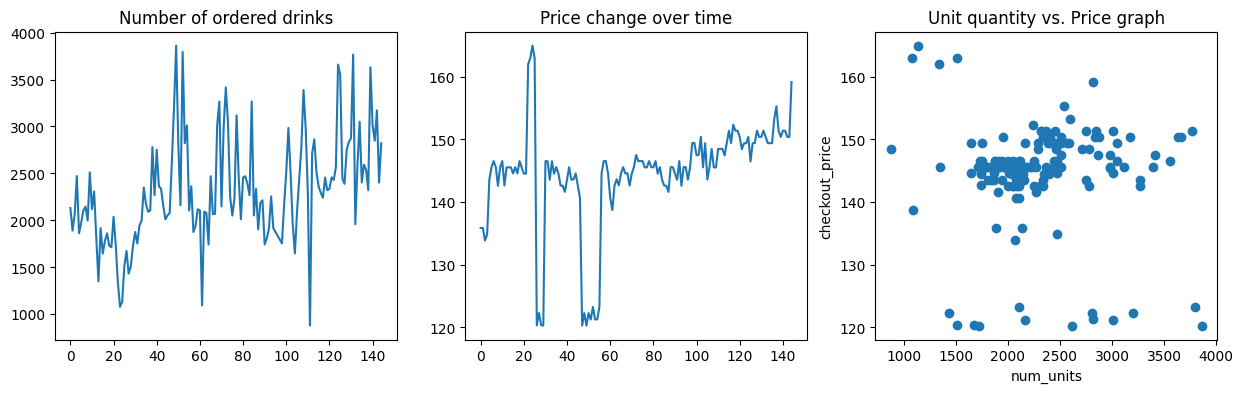

In [14]:
plt.figure('Dependence', figsize=(15,4))

plt.subplot(1,3,1)
plt.plot(df_orders['num_units'])
plt.title('Number of ordered drinks')

plt.subplot(1,3,2)
plt.plot(df_orders['checkout_price'])
plt.title('Price change over time')

plt.subplot(1,3,3)
plt.scatter(df_orders['num_units'], df_orders['checkout_price'])
plt.title("Unit quantity vs. Price graph")
plt.xlabel('num_units')
plt.ylabel('checkout_price')

plt.show()

There is virtually no clear relationship between order quantity and price: prices mostly stay within a narrow range (140–150) regardless of the volume ordered

#### Correlation coefficient

In [15]:
r, p_value = pearsonr(df_orders['num_units'], df_orders['checkout_price'])     
print('Correlation value (r) = ', r)
print('Significance (p_value) = ', p_value)

Correlation value (r) =  -0.08066955837086605
Significance (p_value) =  0.33476736871453383


Thus, the value of the Pearson correlation coefficient, ∣r∣ ≤ 0.3, indicates a **very weak inverse linear relationship** between the variables. At the same time p-value = 0.3348 is significantly greater than the threshold of 0.05, that is, this “relationship” is **not statistically insignificant**. In other words, based on these data, it is impossible to conclude about a linear relationship between volume and price

#### Granger Causality Test  
Granger Causality Test checks whether knowing past values of series 𝑋 helps improve the forecasting of series 𝑌, beyond what past values of 𝑌 alone provide.

In [16]:
grangercausalitytests(df_orders[['checkout_price', 'num_units']], maxlag = 12, verbose = True)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0006  , p=0.9798  , df_denom=141, df_num=1
ssr based chi2 test:   chi2=0.0007  , p=0.9796  , df=1
likelihood ratio test: chi2=0.0007  , p=0.9796  , df=1
parameter F test:         F=0.0006  , p=0.9798  , df_denom=141, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.1660  , p=0.3147  , df_denom=138, df_num=2
ssr based chi2 test:   chi2=2.4165  , p=0.2987  , df=2
likelihood ratio test: chi2=2.3964  , p=0.3017  , df=2
parameter F test:         F=1.1660  , p=0.3147  , df_denom=138, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.9001  , p=0.4430  , df_denom=135, df_num=3
ssr based chi2 test:   chi2=2.8403  , p=0.4169  , df=3
likelihood ratio test: chi2=2.8123  , p=0.4215  , df=3
parameter F test:         F=0.9001  , p=0.4430  , df_denom=135, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.8025  , p=0.5256  

c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


{np.int64(1): ({'ssr_ftest': (np.float64(0.0006428993467985398),
    np.float64(0.9798072870331174),
    np.float64(141.0),
    np.int64(1)),
   'ssr_chi2test': (np.float64(0.0006565780563048917),
    np.float64(0.9795574193015217),
    np.int64(1)),
   'lrtest': (np.float64(0.0006565765595496487),
    np.float64(0.9795574425971992),
    np.int64(1)),
   'params_ftest': (np.float64(0.0006428993468832068),
    np.float64(0.9798072870316425),
    np.float64(141.0),
    1.0)},
   array([[0., 1., 0.]])]),
 np.int64(2): ({'ssr_ftest': (np.float64(1.1660264693087512),
    np.float64(0.3146533335738966),
    np.float64(138.0),
    np.int64(2)),
   'ssr_chi2test': (np.float64(2.416547610306542),
    np.float64(0.29871247056916433),
    np.int64(2)),
   'lrtest': (np.float64(2.396356228351692),
    np.float64(0.30174345355305854),
    np.int64(2)),
   'params_ftest': (np.float64(1.1660264693089706),
    np.float64(0.31465333357382463),
    np.float64(138.0),
    2.0)},
   array([[0., 0., 1., 0.

Across all tested lags (1–12) in the results for 'price → num_orders':
* The SSR-based F-test and the other tests all yield p > 0.05
* For no lag do we reject that 'price does not Granger-cause num_orders'

To sum up, there is no statistically significant predictive power of price on the number of orders over a 12-week horizon. In other words, past values of price do not improve the demand forecast beyond what demand’s own history already provides

### 4.3 Detecting Outliers

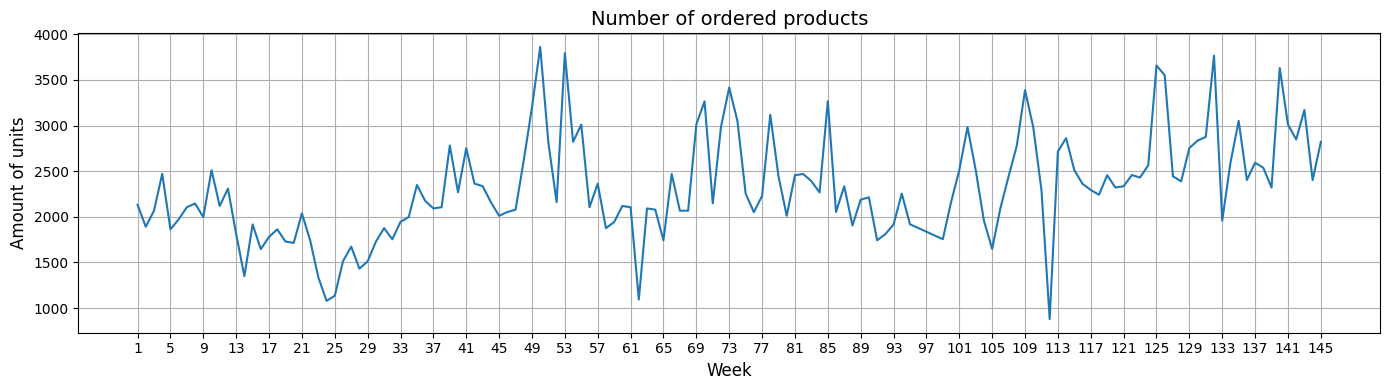

In [17]:
# Graph of data to determine outliers
plt.figure(figsize = (14, 4))  
plt.plot(df_orders['week'], df_orders['num_units'])              
plt.title('Number of ordered products', fontsize = 14)
plt.xlabel('Week', fontsize = 12)
plt.ylabel('Amount of units', fontsize = 12)
plt.xticks(range(min(df_orders.week), max(df_orders.week) + 1, 4))
plt.grid(True)
plt.tight_layout()
plt.show()

Outliers in number of ordered beverages:
 49     3862
52     3794
111     879
124    3659
125    3552
131    3767
139    3631
Name: num_units, dtype: int64


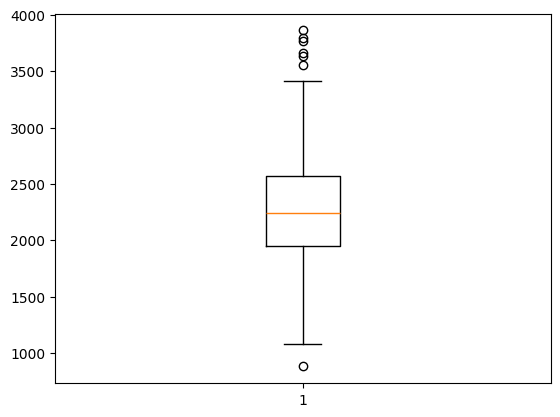

In [18]:
# IQR method emissions
Q1 = df_orders['num_units'].quantile(0.25)
Q3 = df_orders['num_units'].quantile(0.75)
IQR = Q3 - Q1
lower, upper = Q1 - 1.5 * IQR, Q3 + 1.5 * IQR

outliers = df_orders[(df_orders['num_units'] < lower) | (df_orders['num_units'] > upper)]
print('Outliers in number of ordered beverages:' + '\n', outliers['num_units'])

# Graph of Outliers
plt.boxplot(df_orders['num_units'])
plt.show()

In [19]:
# Determine in which months our outliers were (1 year = 0-51 week)
def week_recogniton(week_num):
    year = week_num // 52
    week_of_year = week_num % 52
    month = math.ceil((week_of_year + 1) * 12 / 52)
    start_week = math.floor((month - 1) * 52 / 12)
    week_in_month = week_of_year - start_week + 1
    return year + 1, month, week_in_month 

# Print index and number of week (from 1) for outliers
for w in outliers.index:
    year, m, wm = week_recogniton(w)
    print(f"Outliers with index {w} (week № {w + 1}): {wm} week of {calendar.month_name[m]} in the {year} year")

Outliers with index 49 (week № 50): 3 week of December in the 1 year
Outliers with index 52 (week № 53): 1 week of January in the 2 year
Outliers with index 111 (week № 112): 4 week of February in the 3 year
Outliers with index 124 (week № 125): 4 week of May in the 3 year
Outliers with index 125 (week № 126): 1 week of June in the 3 year
Outliers with index 131 (week № 132): 2 week of July in the 3 year
Outliers with index 139 (week № 140): 2 week of September in the 3 year


We note that the spikes in order levels do not occur on holidays, which means that this is not explained by increased customer demand in preparation for the holidays. We can also conclude that this is not a seasonal anomaly, since the spikes do not repeat every year.  

Unfortunately, we do not have data on whether these were critical business events such as sales, promotions, or marketing campaigns. Also, there was no dependence of the increase in the order volume on the price. Therefore, in this case, we will prefer to change the outliers.

* For outliers with indexes 49, 52, 111, 131, 139 we will find the median taking into account three values: previous, present and future.
* For values ​​with indices 124, 125, we will use the average of two neighbors.

In [20]:
# Median with window = 3
outliers1 = [49, 52, 111, 131, 139]

rolling_med = df_orders['num_units'].rolling(window = 3, center = True).median()
df_orders.loc[outliers1, 'num_units'] = rolling_med.loc[outliers1]
print(df_orders.loc[outliers1, 'num_units'])

# Average of two neighbors
outliers2 = [124, 125]

for i in outliers2:
    prev_val = df_orders.at[i - 1, 'num_units']
    next_val = df_orders.at[i + 1, 'num_units']
    df_orders.at[i, 'num_units'] = (prev_val + next_val) / 2
print(df_orders.loc[outliers2, 'num_units'])

49     3201
52     2822
111    2294
131    2876
139    3012
Name: num_units, dtype: int64
124    3059.0
125    2751.5
Name: num_units, dtype: float64


C:\Users\user\AppData\Local\Temp\ipykernel_18096\3210987412.py:14: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '2751.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_orders.at[i, 'num_units'] = (prev_val + next_val) / 2


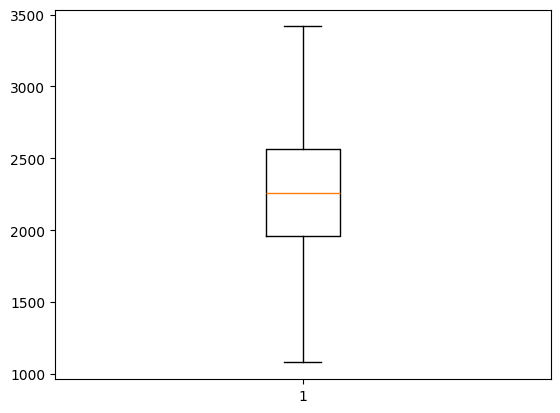

In [21]:
# Checking final data
plt.boxplot(df_orders['num_units'])
plt.show()

## 5. Modeling  
Create a separate table with only the data column we need

In [22]:
df_work = pd.DataFrame({'week': df_orders.week,'num_units': df_orders.num_units.astype(int)})
df_work.set_index('week', inplace=True)
df_work

,num_units
week,
1,2132
2,1891
3,2067
4,2472
5,1863
...,...
141,3012
142,2848
143,3172


### 5.1. Preparing functions

Creating functions for those actions that will be repeated several times:

In [23]:
# Plotting graphs with one or couple of data series
def plot_graph(*ys, title = None, figsize = (10, 4), xticks = range(0, 146, 6), labels = None, legend = False):                   
    plt.figure(figsize = figsize)

    for i, y in enumerate(ys):
        label = labels[i] if labels and i < len(labels) else f'Dataset {i+1}'
        plt.plot(y, label = label)                

    if title:
        plt.title(title, fontsize = 14)
    plt.xlabel('Week', fontsize = 12)
    plt.ylabel('Amount of units', fontsize = 12)
    
    plt.xticks(xticks)
    
    if legend: plt.legend()

    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [24]:
# Plotting autocorrelation and partial autocorrelation graphs
def autoreg(data, lag = 62):         
    plot_acf(data, lags = lag)       
    plot_pacf(data, lags = lag)
    plt.tight_layout()
    plt.show()

In [25]:
# KPSS test
def test_by_KPSS(data, regression = 'c'):                 
    kpsstest = kpss(data, regression = regression)                  
    print ('Results of KPSS Test: %f' % kpsstest[0])
    print('p-value: %f' % kpsstest[1])
    print('Critical Values:')
    kpss_output = pd.Series(kpsstest[0:3], index = ['Test Statistic','p-value','Lags Used'])
    for key,value in kpsstest[3].items():
        print('\t%s: %.3f' % (key, value))

In [26]:
# Augmented Dickey–Fuller test (ADF)
def test_by_AdFuller(data, regression = 'c'):                            
    result = adfuller(data, regression = regression)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

### 5.2 Seasonal–Trend Decomposition

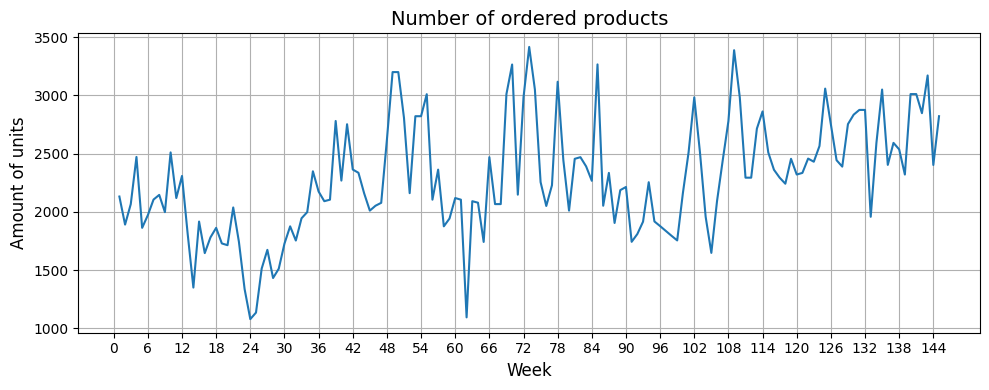

In [27]:
# Outputting a graph of the final input data
plot_graph(df_work, title = 'Number of ordered products')

#### Trend  
Use a **Hodrick-Prescott Filter** to determine the trend movements in data. Since we have weekly data, then λ = 129 600

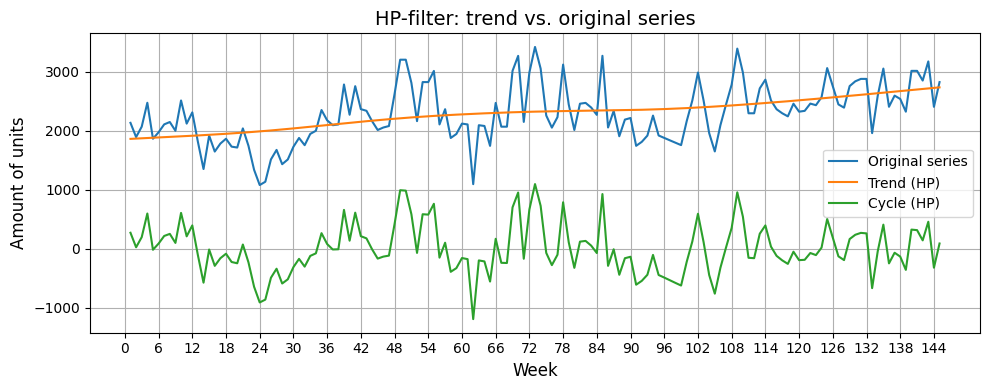

In [28]:
trend, cycle = hpfilter(df_work, lamb = 129600)
plot_graph(df_work, cycle, trend, title = 'HP-filter: trend vs. original series', labels = ['Original series', 'Trend (HP)', 'Cycle (HP)'], legend = True)

It can be seen that with the value λ = 129 600, the trend looks very smooth.  
Since the trend is important to us, we will try to consider alternative methods to see more locally: **LOESS smoothing**

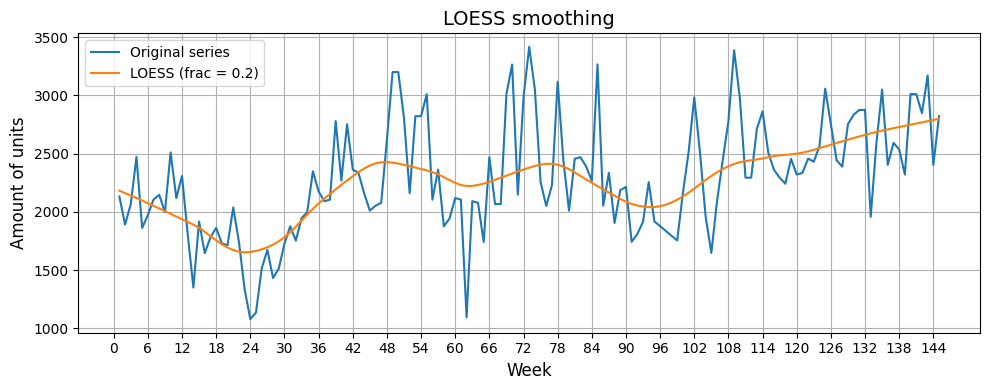

In [29]:
trend_loess = lowess(df_work['num_units'], df_work.index.astype(int), frac = 0.2, return_sorted = False)
trend_loess = pd.Series(trend_loess, index = df_work.index)

plot_graph(df_work, trend_loess, title = 'LOESS smoothing', labels = ['Original series', 'LOESS (frac = 0.2)'], legend = True)

Thus, the trend is non-linear: the rate of growth and decline changes over time. The LOESS chart also shows that:
- The trend clearly "tilts" down until ~24th week, then there is an increase, then a small decrease again and an increase by the end of the series;
- The amplitude of short-term fluctuations (LOESS residuals) is approximately constant throughout, does not “inflate” with a high trend -> Model - additive

#### Seasonality

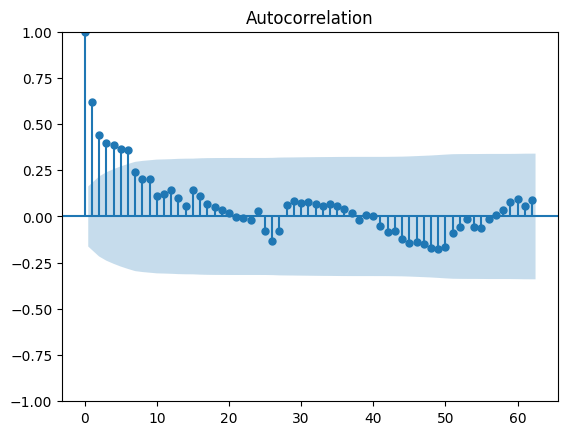

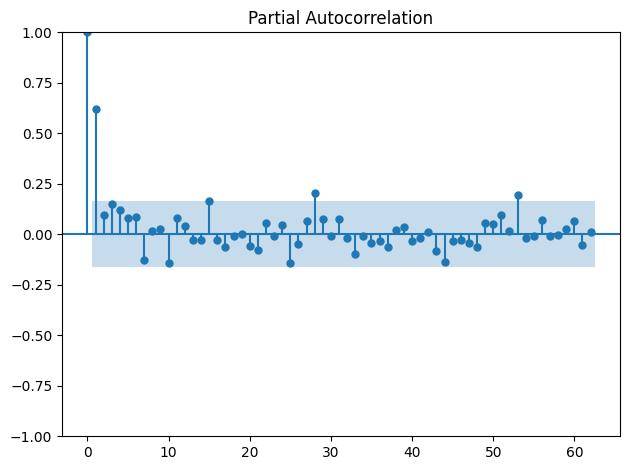

In [36]:
# Plot the autocorrelation and partial autocorrelation graphs
autoreg(df_work)

What we can see on the autocorrelation plot:
* Rapid decay of autocorrelation after lag 1 – 6: the series is highly correlated with itself at very short horizons (6 weeks), then correlations taper off toward zero.
* No prominent spikes at 'seasonal' lags (52 weeks for annual seasonality, or 12 weeks for quarterly). Any small blips around those lags remain within the confidence bounds, so they’re not statistically significant.

Conduct additional **Spectral analysis** _(Fast Fourier Transform)_ to exclude the suspicion of a cycle (e.g. annual, quarterly) despite the ACF.

In [39]:
# For the frequency array we use d = 1, since the samples are taken with a step of one week
avg_units = df_work['num_units'].values - df_work['num_units'].mean()
fft = np.fft.fft(avg_units)
freqs = np.fft.fftfreq(len(avg_units), d = 1)

# ignore the zero frequency and take the peak
peak_freq = freqs[np.argmax(np.abs(fft)[1:]) + 1]
period = int(round(1 / peak_freq))
print("Estimated period:", period)

Estimated period: 72


What both methods tell:
* **Autocorrelation:** The data show short-term dependence, but no clear seasonal cycle. There is no lag at which the ACF jumps back up conspicuously above the significance bands;
* **Fast Fourier Transform:** the dominant spectral peak was found at a frequency corresponding to a period of 72 weeks (the strongest repeating cycle).

#### Decompositon

In [22]:
# STL decompositon with perios equled 52 weeks (~ 1 year)
stl = STL(df_work, period = 52)
stl_fit = stl.fit()

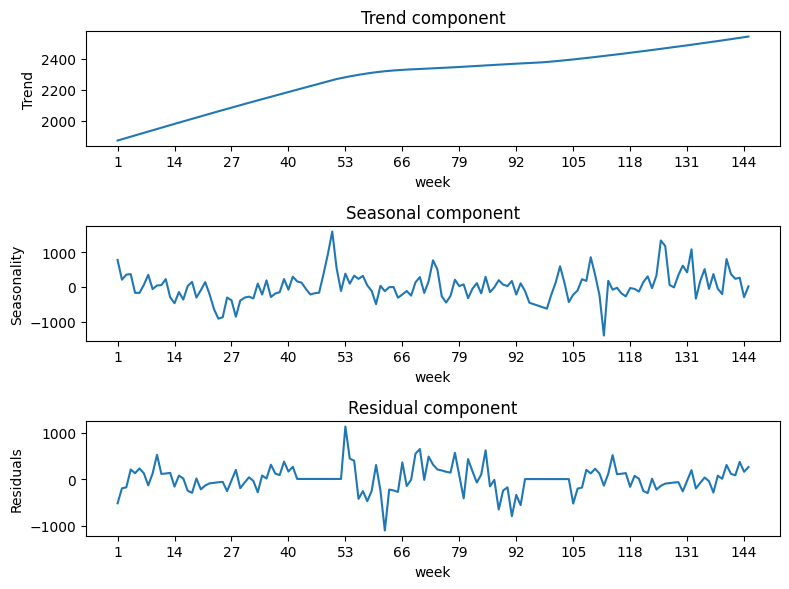

In [23]:
plt.figure(figsize = (8, 6))

# Trend
plt.subplot(311)
stl_fit.trend.plot()
plt.title('Trend component')
plt.ylabel('Trend')
plt.xticks(range(1,146, 13))
plt.tight_layout()

# Seasonality
plt.subplot(312)
stl_fit.seasonal.plot()
plt.title('Seasonal component')
plt.ylabel('Seasonality')
plt.xticks(range(1,146, 13))
plt.tight_layout()

# 3.3 Residual - not explained by trend and seasonality
plt.subplot(313)
stl_fit.resid.plot()
plt.title('Residual component')
plt.ylabel('Residuals')
plt.xticks(range(1,146, 13))
plt.tight_layout()

plt.show()

After decomposition we can draw the following conclusions:
1) The time series graph clearly shows a steady upward trend: orders volume gradually increases over time;
2) A regular seasonal component with a period of 52 weeks (annual seasonality) was identified. The amplitude of seasonal fluctuations reaches about 3 000 units: this indicates that in some periods of the year, orders are consistently higher;

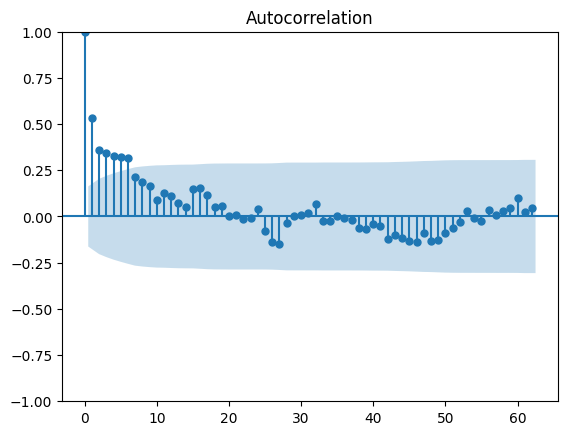

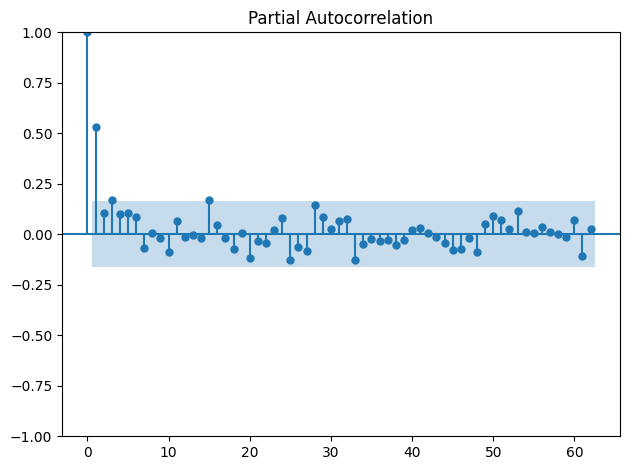

In [24]:
# Autocorrelation and partial autocorrelation
autoreg(df_work)

In [25]:
# Check for stationarity
test_by_KPSS(df_work)
print('')
test_by_AdFuller(df_work)

Results of KPSS Test: 0.745295
p-value: 0.010000
Critical Values:
	10%: 0.347
	5%: 0.463
	2.5%: 0.574
	1%: 0.739

ADF Statistic: -3.868856
p-value: 0.002276
Critical Values:
	1%: -3.477
	5%: -2.882
	10%: -2.578


C:\Users\user\AppData\Local\Temp\ipykernel_18716\3308023662.py:3: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpsstest = kpss(data, regression = regression)
